<a href="https://colab.research.google.com/github/ashkolikov/chimaera/blob/main/Example_Human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ashkolikov/chimaera

In [ ]:
# connect to google drive if you want to save model and logs
from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE = "/content/gdrive/My Drive/"

In [ ]:
!pip install biopython
!pip install cooler
!pip install cooltools

from IPython.display import clear_output
clear_output()
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import gc

from chimaera.dataset import DataMaster
from chimaera.training import ModelMaster

In [ ]:
# download files
!wget https://storage.googleapis.com/basenji_hic/tutorials/coolers/HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool
!wget https://storage.googleapis.com/basenji_barnyard/hg38.ml.fa.gz
!gunzip ./hg38.ml.fa.gz
clear_output()

genome = 'hg38.ml.fa'
hic_file = 'HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool'

In [ ]:
# Loading data for training

# YOU DON'T NEED TO RUN IT IF YOU DON'T WANT TO TRAIN A NEW MODEL OR RUN AN EXISTING ONE ON ANTOTHER DATASET
# because the folder with the saved model already stores the parameters of the dataset on which it was 
# trained - in order not to confuse them, it is recommended not to enter them manually.

# run DataMaster.__doc__ for more info

# this is one of possible sets of parameters:
data = DataMaster(hic_file = hic_file, 
                 genome_file_or_dir = genome, 
                 fragment_length = 2**18,
                 sigma = 2, # for gaussian blur of maps
                 chroms_to_exclude = ['chrX', 'chr14','chr15','chr16','chr17'], # these chromosomes are not in train or val samples so can be used for testing
                 scale = None, # maps are not scaled so we will use linear activation function in the decoder
                 map_size = 64, # each map will be interpolated to size 64x64
                 nan_threshold = 0.2, # maps with >20% of NaNs will be thrown
                 rev_comp = False, # no stochastic reverse-complement
                 stochastic_sampling = False,
                 shift_repeats = 1, # dataset will be split in one way, each region will be presented only once in the dataset
                 expand_dna = False, # do not use DNA context
                 dna_encoding = 'one-hot',
                 val_split = ('first', 64), # validatin sample is 64 first objects in the dataset
                 cut_chromosome_ends = 2**22, # cuts each chromosome (used with excess) - to awoid telomeres
                 sample_seed = 0) # seed for random subsample for visualization

In [ ]:
# Model
# Now it's not stored in external file to make it easier to experiment with it

class Chimaera():
    '''The model itself'''

    def __inint__(self, latent_dim = 24):
        self.latent_dim = latent_dim
        self.output_scale = None
        self.input_len = None
        self.map_size = None

    def choose_activation(self):
        if self.output_scale is None:
            self.out_activation = 'linear'
        elif self.output_scale == (-1, 1):
            self.out_activation = 'tanh'
        elif self.output_scale == (0, 1):
            self.out_activation = 'tanh'
        else:
            self.out_activation = 'linear'
    
    def update(self, input_len, map_size, output_scale):
        self.input_len = input_len
        self.map_size = map_size
        self.output_scale = output_scale
        self.choose_activation()

    def enc(self):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(input_shape=(self.map_size, self.map_size, 1), filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(self.latent_dim, activation='linear')])
        return model

    def dec(self):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(input_shape=(self.latent_dim, ), units=16*16*32, activation='relu'),
                tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation=self.out_activation)])
        return model

    def model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(self.input_len, 4)))

        model.add(tf.keras.layers.Conv1D(64, 11, padding='same', activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

        pooling_range = int(np.log2(self.input_len)) - 8
        for block in range(pooling_range):
            model.add(tf.keras.layers.Conv1D(64, 5, padding='same', dilation_rate = 2, activation='relu'))
            model.add(tf.keras.layers.Dropout(0.1))
            model.add(tf.keras.layers.BatchNormalization())
            model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.15))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(self.latent_dim))

        model.compile(loss = 'mse', optimizer = 'nadam')

        return model

In [ ]:
# TRAIN A NEW MODEL:

REMOTE_DIR = GDRIVE # your remote folder - for example google drive - or None if you don't want to save
Model = ModelMaster(data, # you can pass data to model
                    saving_dir = REMOTE_DIR + 'Human', # all files will be saved here
                    rewrite = False) # if 'Human' already exists, it will raise exception,
                    # if rewrite is True - folder will be rewritten
Model.build(Chimaera())

In [ ]:
# RUN AN EXISTING MODEL:

MODEL_DIR = 'chimaera/Human_1' # folder with model
Model = ModelMaster(data = None, # data will be loaded using saved information
                    hic_file = hic_file, 
                    genome_file_or_dir = genome,       
                    model_dir = MODEL_DIR,
                    saving_dir = None) # nothing will be saved

DNA data for chr1 is loaded
DNA data for chr10 is loaded
DNA data for chr11 is loaded
DNA data for chr12 is loaded
DNA data for chr13 is loaded
DNA data for chr2 is loaded
DNA data for chr20 is loaded
DNA data for chr21 is loaded
DNA data for chr22 is loaded
DNA data for chr3 is loaded
DNA data for chr4 is loaded
DNA data for chr5 is loaded
DNA data for chr6 is loaded
DNA data for chr7 is loaded
DNA data for chr8 is loaded
DNA data for chr9 is loaded

Maps are zoomed 0.5 times
For 64x64 map used 262144 nucleotide fragments
Hi-C data for chr1 is loaded
Hi-C data for chr10 is loaded
Hi-C data for chr11 is loaded
Hi-C data for chr12 is loaded
Hi-C data for chr13 is loaded
Hi-C data for chr2 is loaded
Hi-C data for chr20 is loaded
Hi-C data for chr21 is loaded
Hi-C data for chr22 is loaded
Hi-C data for chr3 is loaded
Hi-C data for chr4 is loaded
Hi-C data for chr5 is loaded
Hi-C data for chr6 is loaded
Hi-C data for chr7 is loaded
Hi-C data for chr8 is loaded
Hi-C data for chr9 is loaded


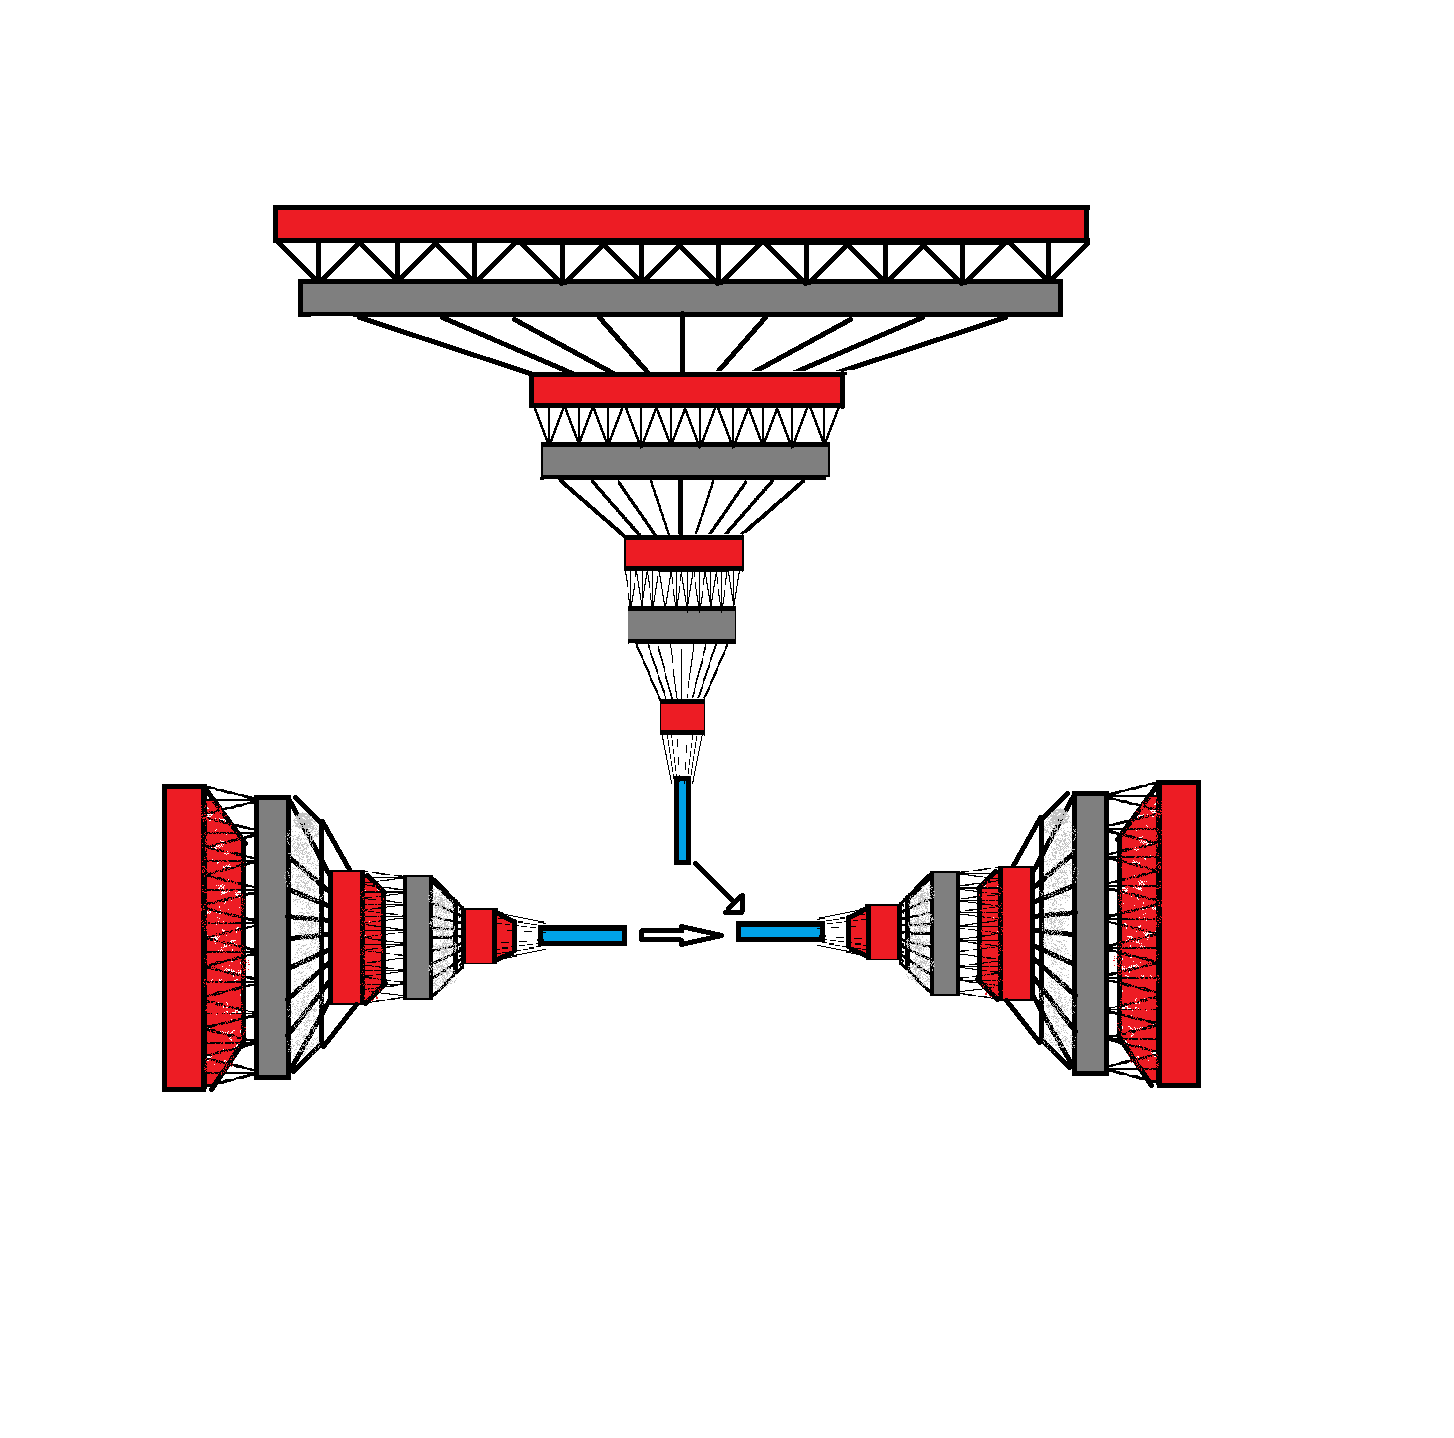

In [ ]:
# TRAIN THE MODEL
Model.train(epochs = 1000,
            batch_size = 8,
            callbacks='classical') # if 'full', each epoch will generate and save visualization of progress

In [ ]:
Model.describe('''
Best model
64 filters, dropout 0.15
Interesting 11 filter
Any other info
etc.
''') # it will save your text in description.txt in the model folder

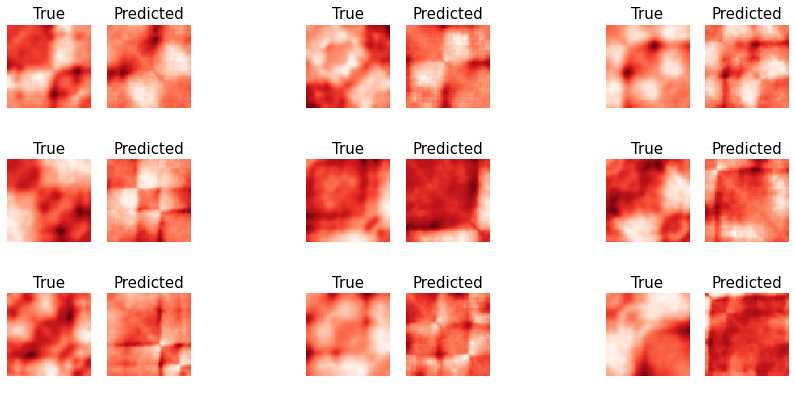

In [ ]:
Model.predict_as_training = False # chose one of two modes of prediction for tensorflow models 
# (sometimes predicting as in training works better for some reason)
Model.plot_results(['val', 10]) # first 10 of validation sample

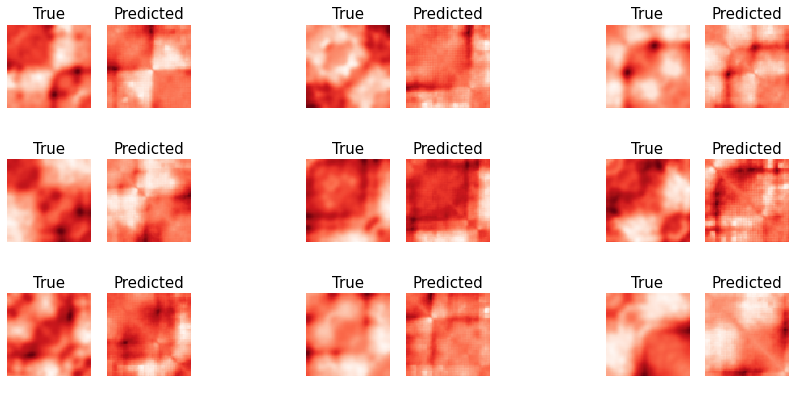

In [ ]:
Model.predict_as_training = True # like in this case
Model.plot_results(['val', 10])

In [ ]:
Model.predict_as_training = False

Model.load_test_chromosome('chr14') # this chromosome wasn't used while training
Model.score(metric = 'pearson') # plots distributions of metrics (in this case - 
# Pearson correlations between true and predicted maps). Another varient ia Spearman
# correlation ('spearman'). Each sample has two plots - the left one describes real
# predictions and the right one is a distribution of correlations between predicted maps
# and random maps from the sample, so it indicates if correlations are meaningfull 
# and a true map correlates with a predicted one better than a random one

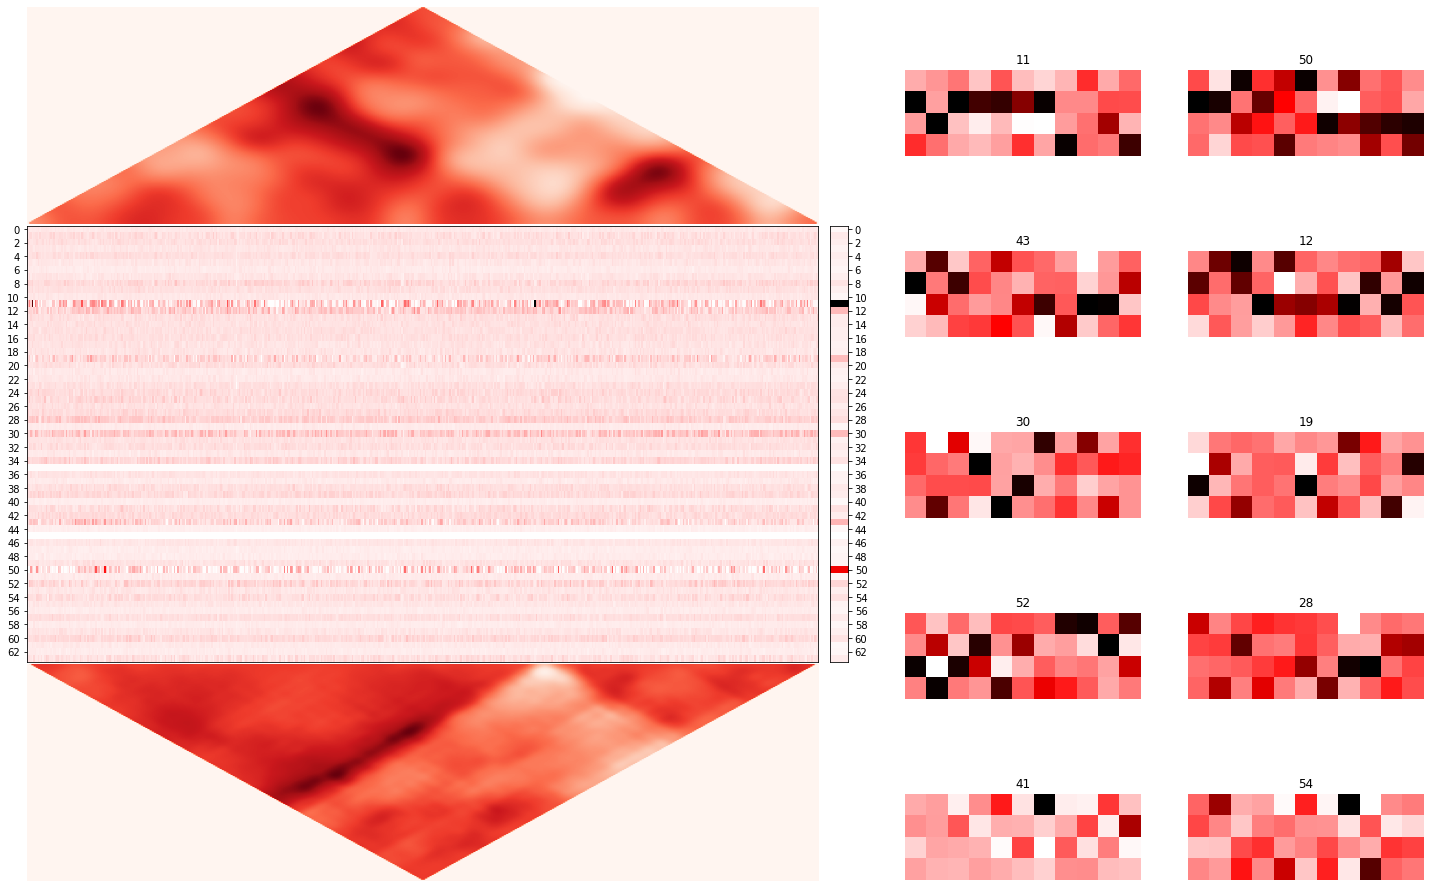

In [ ]:
# GRAPHIC ANALISYS OF FILTERS
# top triangle is a real map, bottom is a predicted one, center is an output of
# the first convolutional block mapped to corresponding map, rows are filters
# right column indicates maximal value in a row minus mean value in a row
# right part of the figure shows top-10 filters by this value
filters = Model.graphic_analisis(20, # number of exploring pair in validation sample
                    theme='light', # color settings
                    n_layers=3, # number of layer to analyse (it should be first convolutional block - in other cases works incorrect)
                    color_shifts={'heatmap': 210, 'filters': 200}, # set color contrast
                    return_filters=True, # returns top-10 filters by max_activation - mean_activation
                    aggregation='max') # aggregate close positions using maximal value (works like MaxPooling)

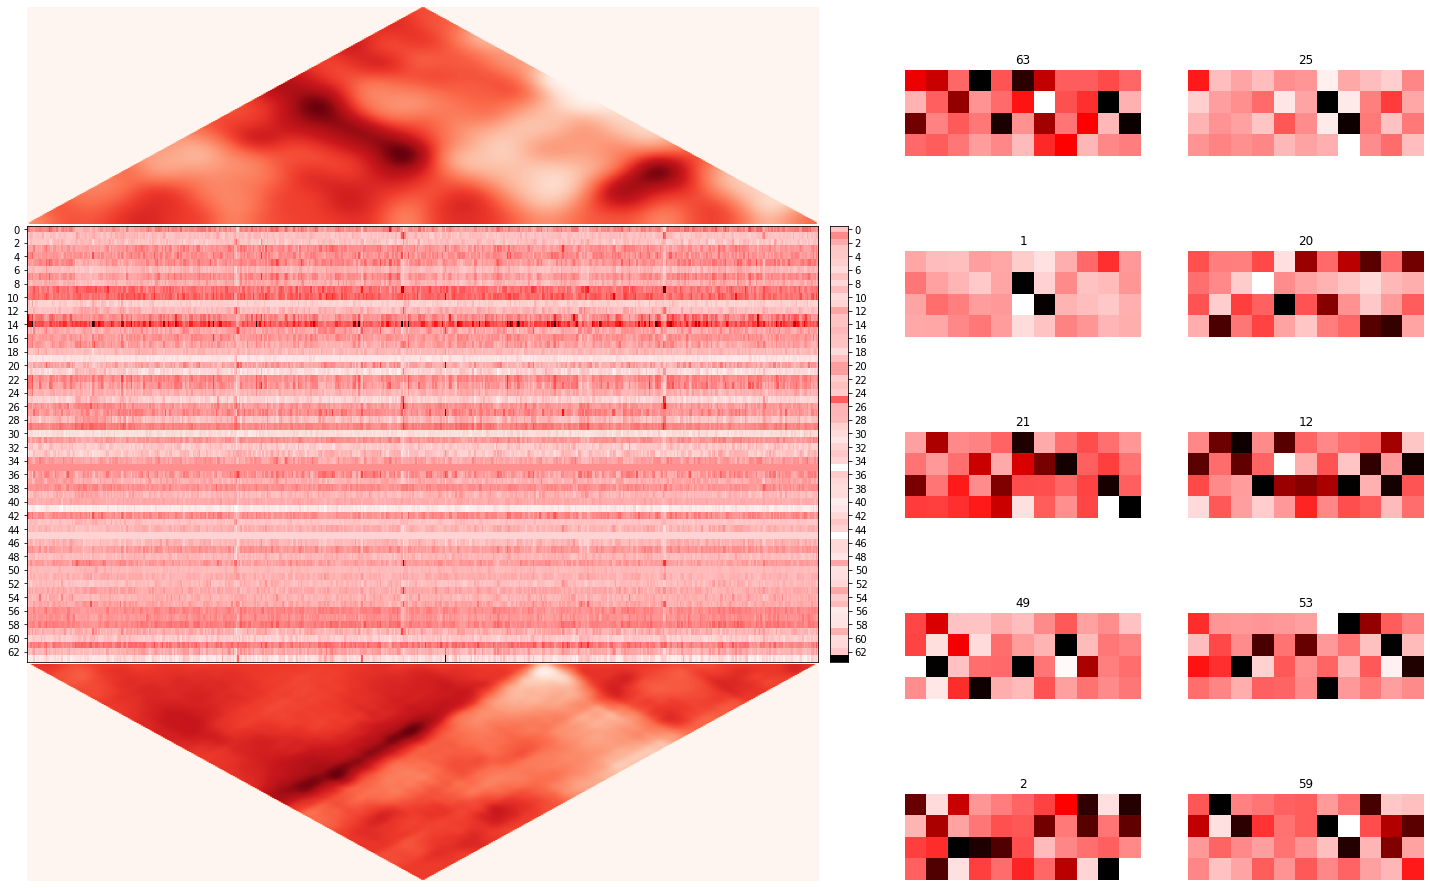

In [ ]:
Model.graphic_analisis(20,
                    theme='light',
                    n_layers=3,
                    color_shifts={'heatmap': 210, 'filters': 200},
                    return_filters=False,
                    aggregation='mean') # aggregate close positions using mean value (works like AveragePooling) - it can show not so so strong but highly enriched motif

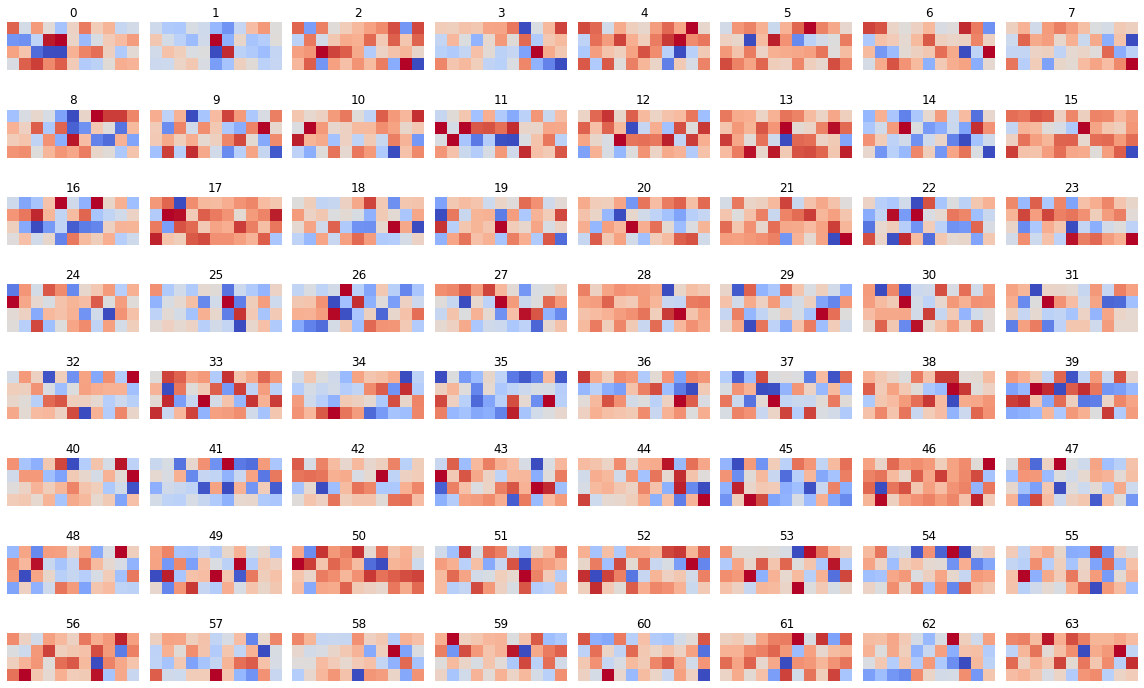

In [ ]:
# look all filters through
Model.plot_filters()

In [ ]:
# INTEGRATED GRADIENTS



def interpolate(x, steps=15):
    alphas = tf.linspace(start=0.0, stop=1.0, num=steps+1)[:, tf.newaxis, tf.newaxis, tf.newaxis]
    x = tf.expand_dims(x, axis=0)
    return alphas * x

def compute_gradients(inputs, model):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        outputs = []
        for input in inputs:
            outputs.append(model(input))
        outputs = tf.stack(outputs)  
    return tape.gradient(outputs, inputs)

def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

def integrated_gradients(model, x, steps=15):
    interpolated_inputs = interpolate(x, steps)
    path_gradients = compute_gradients(interpolated_inputs, model)
    ig = integral_approximation(path_gradients).numpy()
    ig = np.sum(ig[0], axis=1)
    return ig

def plot_ig(ig):
    pass

def clusterize_peaks(ig):
    pass

def get_seqs(ig):
    pass

In [ ]:
ig = integrated_gradients(Model.model, x)

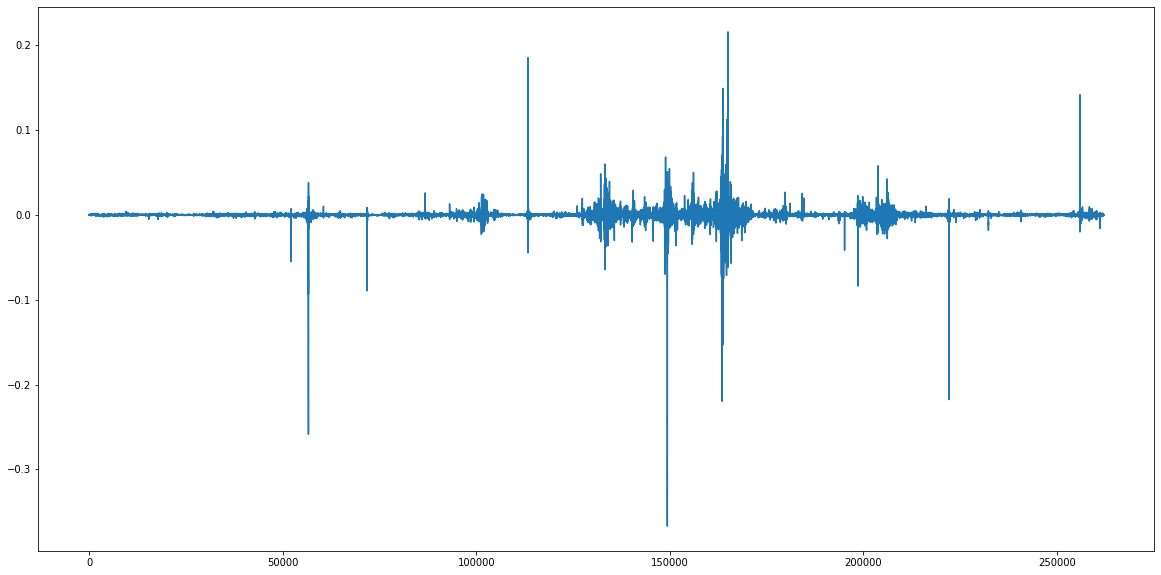

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(ig)

In [ ]:
np.where(ig>0.06)[0]

array([113384, 113385, 113386, 113387, 113388, 113390, 113391, 113392,
       113393, 148929, 163535, 163624, 163645, 163660, 163662, 163663,
       163709, 163711, 163714, 163715, 163795, 163796, 164769, 164772,
       164810, 164812, 164813, 164975, 164995, 165003, 165050, 165052,
       165053, 165054, 165056, 165057, 165058, 256011, 256012, 256013,
       256014, 256015, 256019])

In [ ]:
np.where(ig<-0.1)[0]

array([ 56654,  56659,  56660,  56662, 149382, 149383, 149384, 149385,
       149386, 149387, 149391, 163546, 163548, 163554, 163586, 163729,
       163757, 163765, 163821, 222166, 222167, 222168, 222169, 222170])

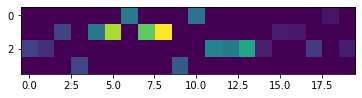

In [ ]:
plt.imshow(np.abs(x[0, 113380:113400].T*ig[113380:113400][None,...]))

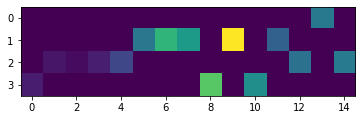

In [ ]:
plt.imshow(np.abs(x[0, 222160:222175].T*ig[222160:222175][None,...]))

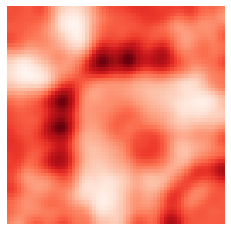

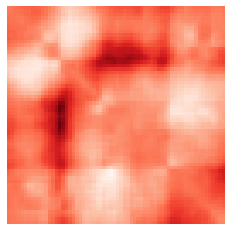

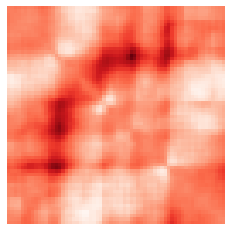

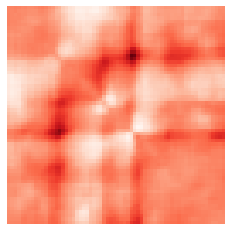

In [ ]:
Model.data.y_val.show(n)
y = Model.data.y_val[n]
y_ = Model.dec(Model.enc(y))[0,...,0]
plt.imshow(y_, cmap='Reds')
plt.axis('off')
plt.show()
Model.predict_and_plot(x)
mut = x.copy()
mut[0, 180000:190000] = 0
Model.predict_and_plot(mut)

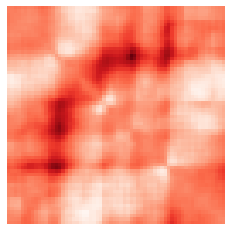

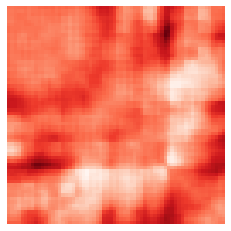

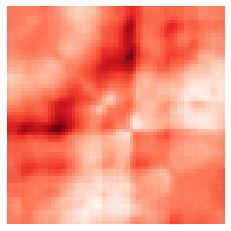

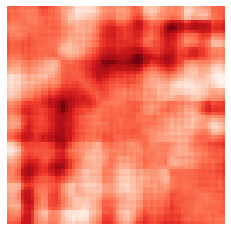

In [ ]:
Model.predict_and_plot(x)
mut = x.copy()
mut[0, ig<-0.02] = 0
Model.predict_and_plot(mut)
mut = x.copy()
mut[0, ig>0.02] = 0
Model.predict_and_plot(mut)
mut[0, ig<-0.02] = 0
Model.predict_and_plot(mut)

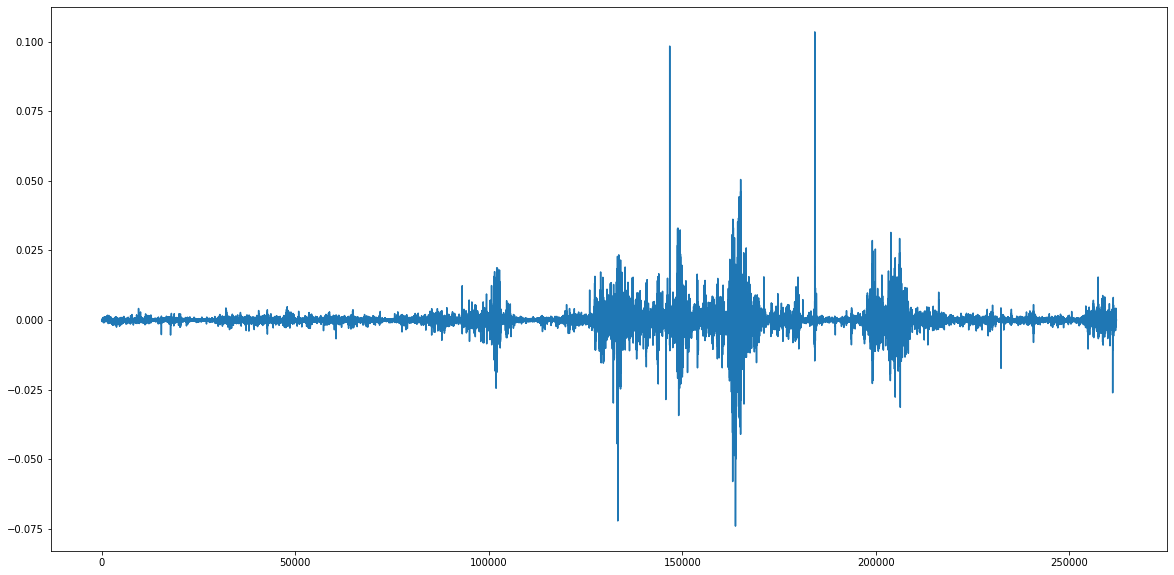

In [ ]:
ig_mut = integrated_gradients(Model.model, mut)
plt.figure(figsize=(20,10))
plt.plot(ig_mut)